In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
import pyper
R = pyper.R(use_pandas='True')

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 5.5, 3.5

# Create Data

In [3]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))

K = 3 # number of coefficients, including the constant

In [4]:
X = np.array(([ [1,  float(np.random.normal(0,1)),float(np.random.normal(0,0.5))] for i in range(2000)  ]))
print(X.shape)

(2000, 3)


In [5]:
beta = np.array([0.5, 1.5, 2.5])
print(beta.shape)
print(beta)

(3,)
[ 0.5  1.5  2.5]


In [6]:
Xbeta = np.dot(X, beta)  + np.random.logistic(scale=0.15, size=X.shape[0]) # do not forget to add an error term
pi = sigmoid(Xbeta)
print(pi.shape)
print(pi[:15])

(2000,)
[ 0.04988014  0.92429694  0.98030715  0.23569637  0.12818588  0.05581448
  0.92416916  0.57318727  0.9020952   0.33947686  0.13526751  0.95144806
  0.72807453  0.8915516   0.99312334]


In [7]:
Y = np.array([np.random.binomial(1, p=prob) for prob in pi])
print(Y.shape)
print(Y[:5])

(2000,)
[0 1 1 1 0]


In [8]:
# Package result
clf.fit(X, Y)
clf.coef_[0]

array([ 0.25245289,  1.54133621,  2.43816054])

# Unbounded Slice Sampling

Reference: http://chasen.org/~daiti-m/diary/?201510

変換:
$$
p = \frac{1}{\exp(-Ax)}, \quad 0 < p < 1
$$

戻す:
$$
x = -\frac{1}{A} \log \left(\frac{1}{p} - 1\right), \quad -\infty < x < \infty
$$

ヤコビアン:<br>
$dx/dp$より、
$$
dx = \frac{1}{A} \frac{1}{p(1-p)}dp
$$

In [9]:
def logsigmoid(x):
    return - np.log(1 + np.exp(-x))

def loglikelihood(beta, X):
    N = X.shape[0]
    lik =  (logsigmoid(np.dot(X, beta)) * Y).sum() + (logsigmoid(-np.dot(X, beta)) * (1 - Y)).sum()  + \
                ( -0.5 * np.log(2 * np.pi) - 0.5 * np.log(100) - (0.5/100) * np.power(beta, 2)).sum() # prior N(0,10)
    
    return lik

def expand(p, A=1):
    # p --> x
    return -(1/A)  * np.log((1/p) - 1)
    
def shrink(x, A=1):
    # x --> p
    return 1 / (1 + np.exp(-A * x) )

In [10]:
num_sampling = 1500
max_shrink_time = 1000
A = 1
chain = np.zeros((num_sampling, K))

for i in range(1, num_sampling):
    param_proposal = chain[i-1].copy()
    param_new = np.zeros(K)
    
    for k in range(K):
        start = 0
        end = 1

        previous_p = shrink( param_proposal[k], A )
        slice_ = loglikelihood( param_proposal, X) - np.log( A * previous_p * (1 -  previous_p) ) + np.log(np.random.uniform())
            # f(x), -\infity < x < \infty を、 0<p<1の範囲に変換しているので、ヤコビアンを忘れないこと
            # np.log( A * previous_p * (1 -  previous_p) )の箇所がそれ
            
        for shrink_time in range(max_shrink_time):
            new_p = np.random.uniform(start, end)
            param_proposal[k] = expand(new_p, A)
            
            newlikelihood = loglikelihood(param_proposal, X) - np.log( A * new_p * (1 -  new_p) )
            
            if  slice_ < newlikelihood :
                break
            # shrink bound (maybe)
            elif previous_p < new_p:
                end = new_p
            elif new_p < previous_p:
                start = new_p
            else:
                break
                
    chain[i, :] = param_proposal.copy()

In [11]:
show_num = 700

0.512194289405


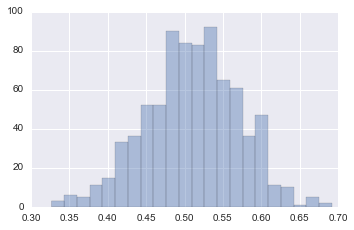

In [12]:
# 0.5
sns.distplot(chain[show_num: , 0], hist=True, kde=False)
#plt.plot([10, 10], [0, 1400], linewidth=2, color='red')
print(np.median(chain[show_num: , 0]))

1.57031569638


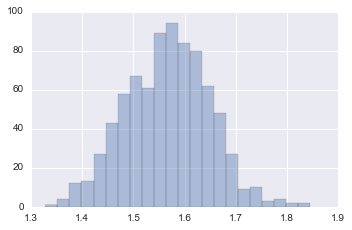

In [13]:
# 1.5
sns.distplot(chain[show_num: , 1], hist=True, kde=False)
#plt.plot([10, 10], [0, 1400], linewidth=2, color='red')
print(np.median(chain[show_num: , 1]))

2.49437382302


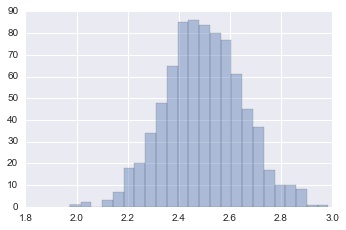

In [14]:
# 2.5
sns.distplot(chain[show_num: , 2], hist=True, kde=False)
#plt.plot([10, 10], [0, 1400], linewidth=2, color='red')
print(np.median(chain[show_num: , 2]))